# Deep mutational scanning of ZIKV E protein
Deep mutational scanning of ZIKV E from the MR766 strain.
Experiments performed by the [Matt Evans lab](http://labs.icahn.mssm.edu/evanslab/).
Sequencing and computational analyses performed by the [Bloom lab](https://research.fhcrc.org/bloom/en.html).

## Set up for analysis
Import Python packages and modules:

In [14]:
import glob
import os
import subprocess
import collections

import pandas
from IPython.display import display, HTML

import dms_tools2
from dms_tools2.ipython_utils import showPDF
print(f"Using dms_tools2 {dms_tools2.__version__}")

Using dms_tools2 2.3.0


Specify information about running analysis:

In [2]:
use_existing = 'yes' # use existing output

ncpus = 16 # max CPUs to use

# directories
resultsdir = './results/'
os.makedirs(resultsdir, exist_ok=True)

Input data found in the [./data/](data) directory:

In [3]:
refseqfile = './data/E.fasta' # sequence of wildtype gene
samplelist = './data/samplelist.csv' # samples sequenced
alignspecsfile = './data/subamplicon_alignspecs.txt'

## Process deep sequencing data
We process the data from the [barcoded subamplicon deep sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) to count the frequency of each codon in each sample.

First, we read in the samples:

In [4]:
samples = (pandas.read_csv(samplelist)
           .assign(name=lambda x: x.library + '-' + x.selection)
           )

display(HTML(samples.to_html(index=False)))

library,selection,antibody,percent_infectivity,R1,name
Lib1,plasmid,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib1-plasmid
Lib2,plasmid,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib2-plasmid
Lib3,plasmid,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib3-plasmid
wildtype,plasmid,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,wildtype-plasmid
Lib1,virus,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib1-virus
Lib2,virus,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib2-virus
Lib3,virus,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib3-virus
wildtype,virus,none,NaN,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,wildtype-virus
Lib1,no-antibody,no-antibody,71.06000,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib1-no-antibody
Lib2,no-antibody,no-antibody,132.77000,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/180...,Lib2-no-antibody


Now we read in the alignment specs for the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html):

In [5]:
with open(alignspecsfile) as f:
    alignspecs = f.read().strip()
print(alignspecs)

1,303,33,38 304,609,38,40 610,903,41,36 904,1200,41,37 1201,1512,36,35


Now we use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html) program to process the deep sequencing data to obtain codon counts:

In [6]:
countsdir = os.path.join(resultsdir, 'codoncounts')
os.makedirs(countsdir, exist_ok=True)

bcsubamp_batchfile = os.path.join(countsdir, 'batch.csv')
samples[['name', 'R1']].to_csv(bcsubamp_batchfile, index=False)

log = ! dms2_batch_bcsubamp \
        --batchfile {bcsubamp_batchfile} \
        --refseq {refseqfile} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 200 \
        --ncpus {ncpus} \
        --use_existing {use_existing}

samples['codoncounts'] = countsdir + '/' + samples['name'] + '_codoncounts.csv'

# check that expected codon counts files created
assert all(map(os.path.isfile, samples.codoncounts)), "missing codon counts files"

print(f"Processed sequencing data to create codon counts files in {countsdir}")

Processed sequencing data to create codon counts files in ./results/codoncounts


Now we look at the plots.
They will all have the following prefix:

In [7]:
bcsubamp_plot_prefix = os.path.join(countsdir, 'summary_')

First, we look at the number of reads and barcodes per sample.
We have plenty of reads for all samples. 
We also have good numbers of aligned barcodes for most samples, but some (particularly, *Lib1-ZKA185*) have very few barcodes.
This probably indicates a problem with bottlenecking the number of molecules going from round 1 to round 2 of the [barcoded subamplicon sequencing](https://jbloomlab.github.io/dms_tools2/bcsubamp.html).

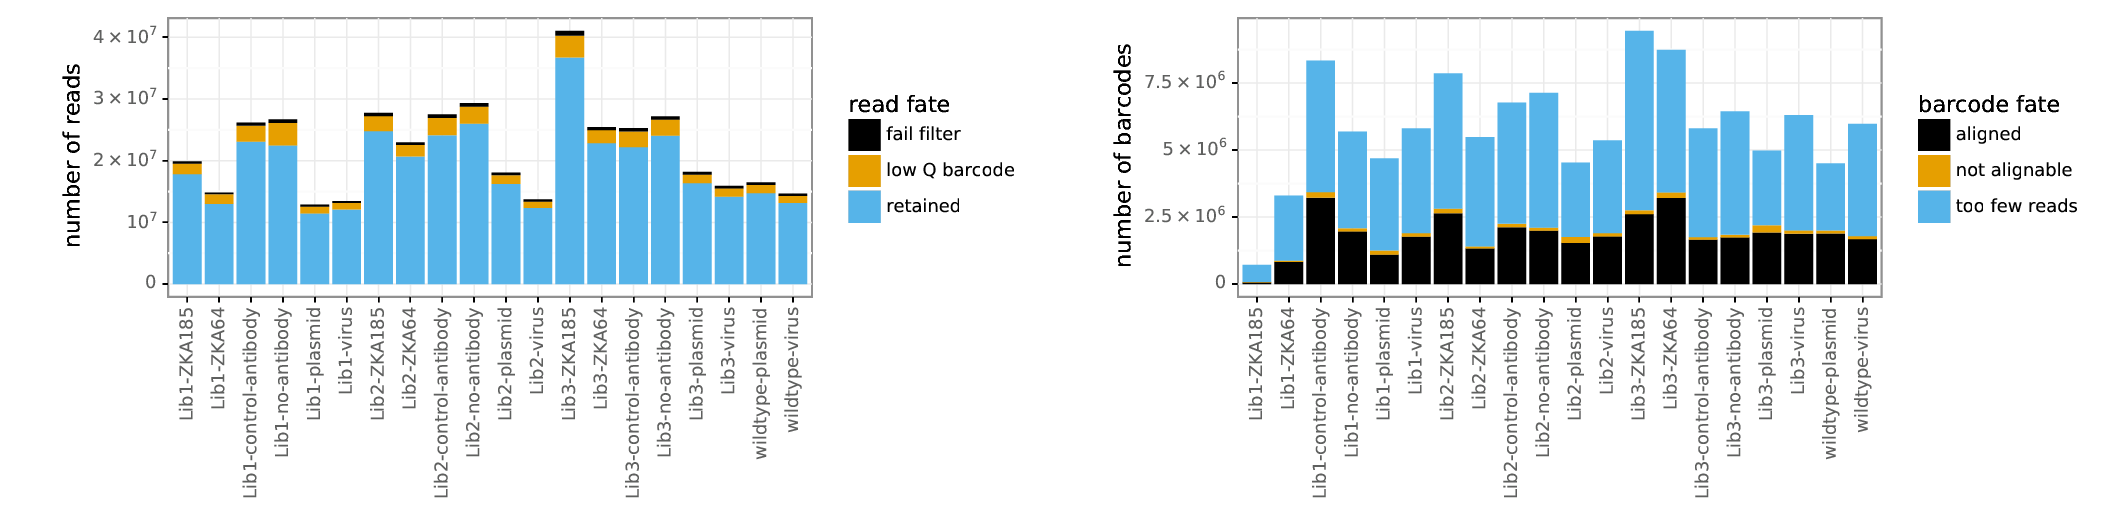

In [8]:
showPDF([bcsubamp_plot_prefix + 'readstats.pdf',
         bcsubamp_plot_prefix + 'bcstats.pdf'])

Next we look at number of reads per barcode.
In all cases, we appear to have over-sequenced (or conversely, bottlenecked too much going from round 1 to round 2) as most barcodes are sequenced > 2 times except for singletons that probably represent sequencing errors. 
This problem is especially sever for *Lib1-ZKA185*, which is probably why we have so few barcodes for this sample.
This does mean that the sequences for the barcodes we did get will be highly reliable, however:

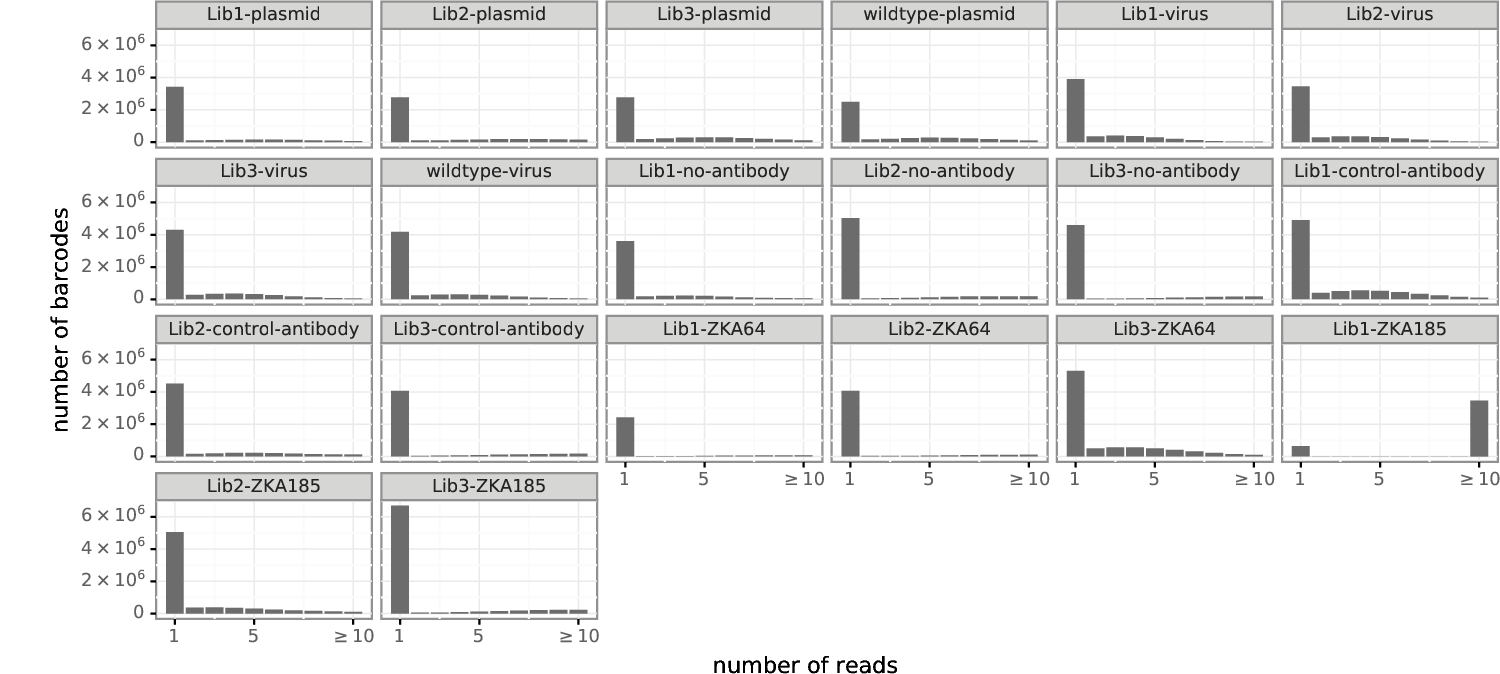

In [10]:
showPDF(bcsubamp_plot_prefix + 'readsperbc.pdf')

Now we look at the depth across the gene.
Except for *Lib1-ZKA185*, the depth seems sufficient for all samples:

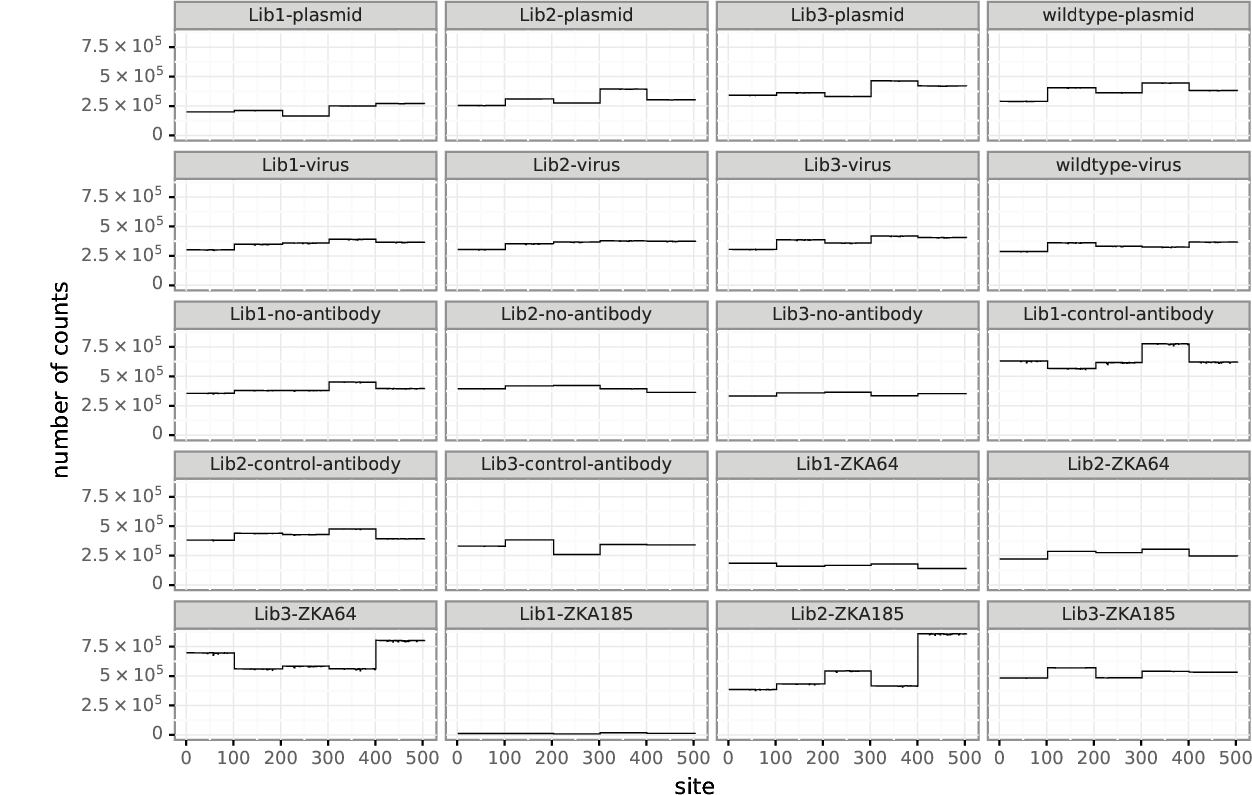

In [11]:
showPDF(bcsubamp_plot_prefix + 'depth.pdf')

Here are the mutation frequencies across the gene.
As expected, there are big peaks in the antibody selected samples, probably because the antibodies selected mutations.
We'll have to wait until more detailed analyses below to tell if these peaks make sense as being escape mutations.

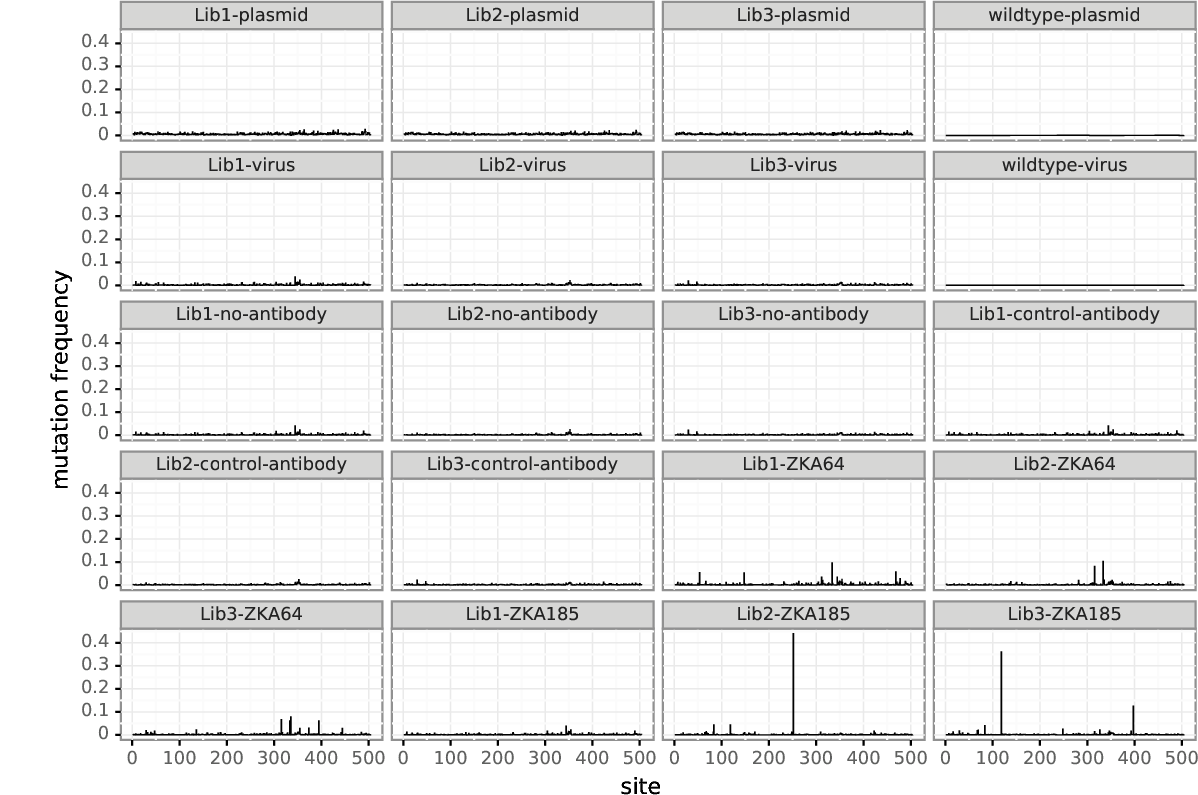

In [12]:
showPDF(bcsubamp_plot_prefix + 'mutfreq.pdf')

We also see that as expected, we get strong selection against stop codons in all samples except the unselected input plasmid library:

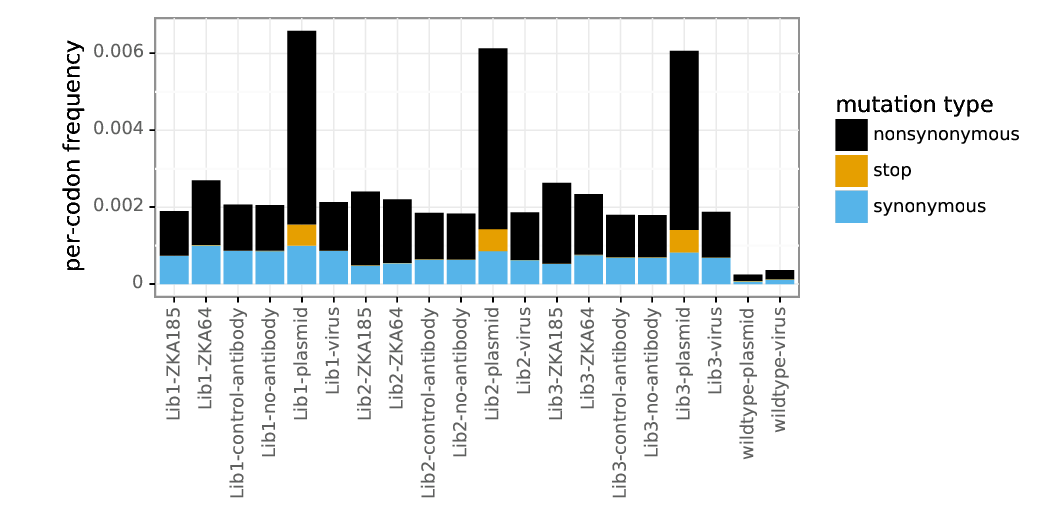

In [13]:
showPDF(bcsubamp_plot_prefix + 'codonmuttypes.pdf')

We have single and multi-nucleotide changes in the libraries, although the single nucleotide changes are perhaps over-represented:

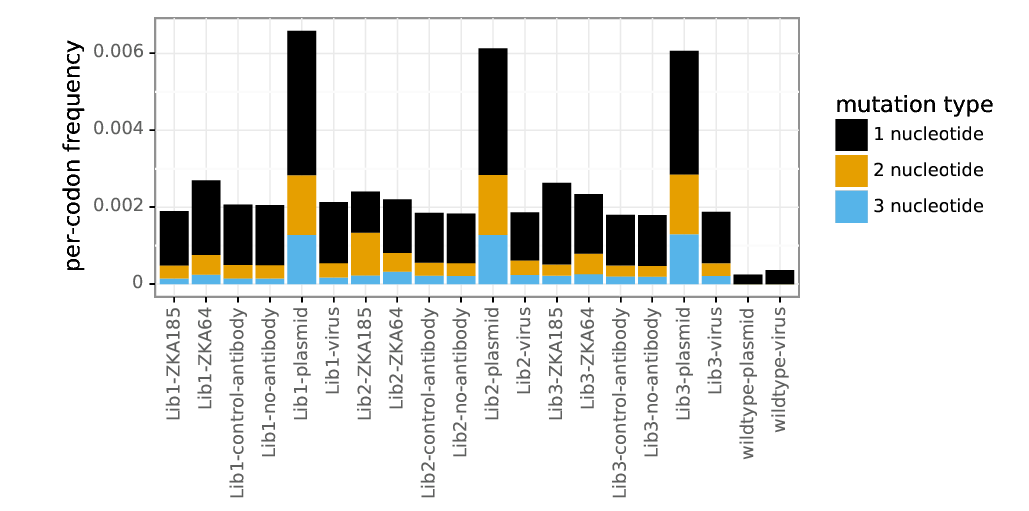

In [14]:
showPDF(bcsubamp_plot_prefix + 'codonntchanges.pdf')

Here are the frequencies of different types of mutations among single-nucleotide codon changes.
We see that unfortunately there does appear to be some oxidative damage to the plasmid samples:Z

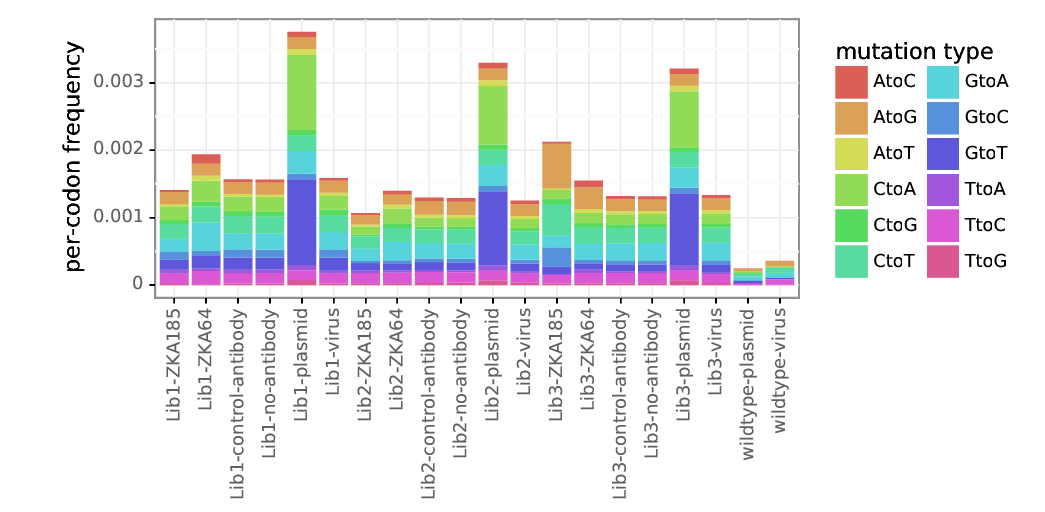

In [15]:
showPDF(bcsubamp_plot_prefix + 'singlentchanges.pdf')

Finally, we look at mutation sampling.
We can see that all possible mutations are sampled very well in the plasmid samples, and that mutation frequencies decrease a lot (as expected due to selection) in the other samples.

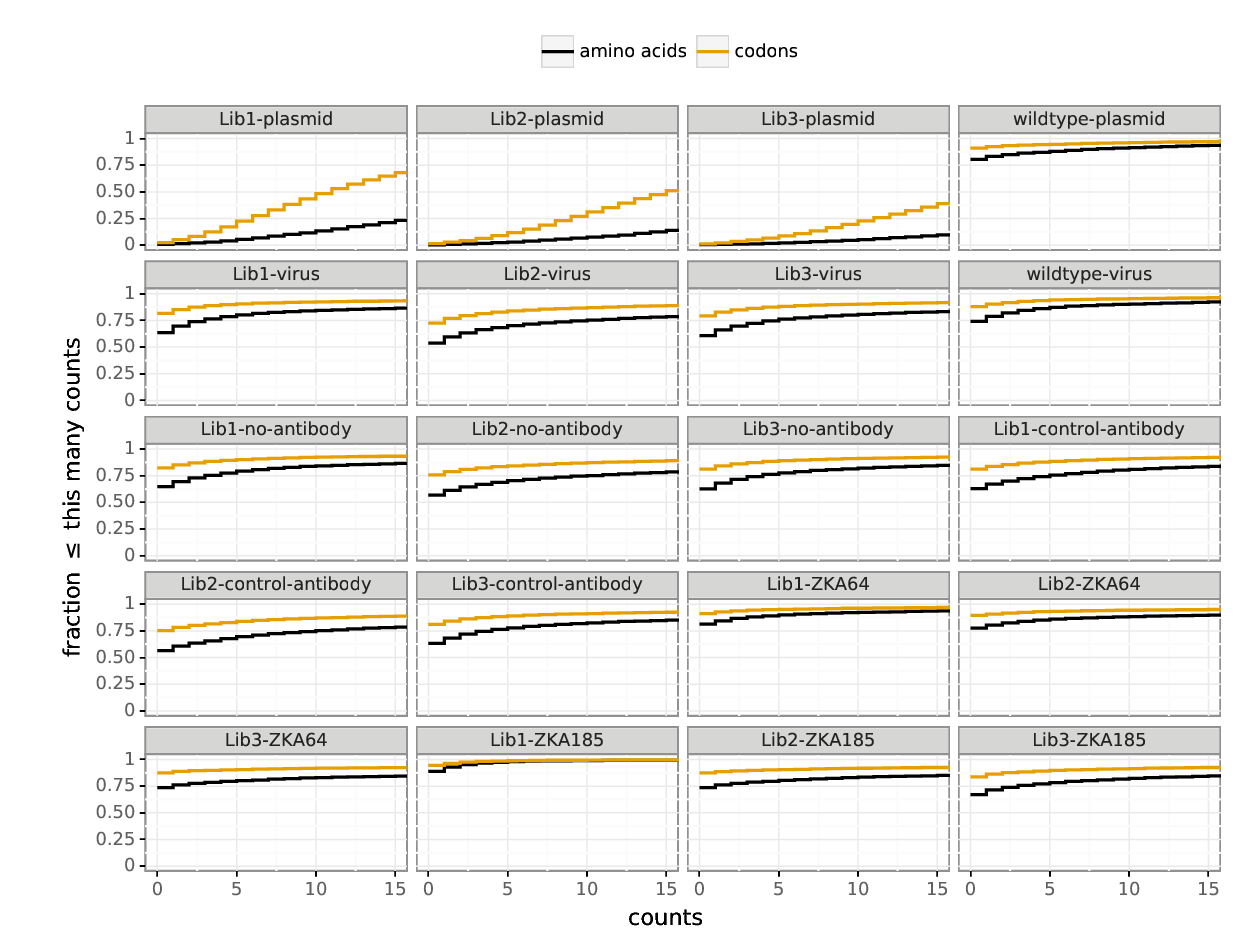

In [11]:
showPDF(bcsubamp_plot_prefix + 'cumulmutcounts.pdf')

## Amino-acid preferences under functional selection
Now we compute the amino-acid preferences under functional selection for viral growth.
To do this, we compare the passaged *virus* samples to the original *plasmid* samples, using the wildtype *plasmid* and *virus* samples as controls to estimate the error rates.
We run the analysis using [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html).

First, construct the data frame with the batch file:

In [16]:
prefs_batch = collections.defaultdict(list)

for lib in samples.library.unique():
    if lib != 'wildtype':
        prefs_batch['name'].append(lib)
        prefs_batch['pre'].append(f'{lib}-plasmid')
        prefs_batch['post'].append(f'{lib}-virus')
        prefs_batch['errpre'].append('wildtype-plasmid')
        prefs_batch['errpost'].append('wildtype-virus')
        
prefs_batch = pandas.DataFrame(prefs_batch)

display(HTML(prefs_batch.to_html(index=False)))

name,pre,post,errpre,errpost
Lib1,Lib1-plasmid,Lib1-virus,wildtype-plasmid,wildtype-virus
Lib2,Lib2-plasmid,Lib2-virus,wildtype-plasmid,wildtype-virus
Lib3,Lib3-plasmid,Lib3-virus,wildtype-plasmid,wildtype-virus


Now run [dms2_batch_prefs](https://jbloomlab.github.io/dms_tools2/dms2_batch_prefs.html):

In [20]:
prefsdir = os.path.join(resultsdir, 'prefs')
os.makedirs(prefsdir, exist_ok=True)

prefs_batchfile = os.path.join(prefsdir, 'batch.csv')
prefs_batch.to_csv(prefs_batchfile, index=False)

log = ! dms2_batch_prefs \
        --indir {countsdir} \
        --batchfile {prefs_batchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing}

INFO:dms2_batch_prefs:Beginning execution of dms2_batch_prefs in directory /fh/fast/bloom_j/computational_notebooks/jbloom/2018/ZIKV_DMS_with_EvansLab

INFO:dms2_batch_prefs:Progress is being logged to ./results/prefs/summary.log
INFO:dms2_batch_prefs:Version information:
	Time and date: Sun Nov 11 08:53:30 2018
	Platform: Linux-3.13.0-143-generic-x86_64-with-debian-jessie-sid
	Python version: 3.6.5 |Anaconda, Inc.| (default, Apr 29 2018, 16:14:56)  [GCC 7.2.0]
	dms_tools2 version: 2.3.0
	Bio version: 1.72
	HTSeq version: 0.11.0
	pandas version: 0.23.4
	numpy version: 1.15.1
	IPython version: 6.5.0
	jupyter version: 1.0.0
	matplotlib version: 3.0.0
	plotnine version: 0.5.0
	natsort version: 5.4.1
	pystan version: 2.16.0.0
	scipy version: 1.1.0
	seaborn version: 0.9.0
	phydmslib version: 2.3.1
	statsmodels version: 0.9.0
	rpy2 version: 2.9.1
	regex version: 2.4.148
	umi_tools version unknown

INFO:dms2_batch_prefs:Parsed the following arguments:
	outdir = ./results/prefs
	ncpus = -1
	us